# Plant Species Classification using leaf images with CNN

Before we dive into actual process of CNN image classifier, we will introduce a little background of the topics discussed in the project.

# Background

## What is a CNN?
   CNN stands for Convolutional Neural Network, a key area in the field of Deep Learning where developers have acheived significant results in Image classification. CNN is a deep neural neural network which learns to classify images or predict the probability of each category of an input by convoluting the input and understanding the important features in the image. For example, it can learn to distinguish an image of cat and dog by learning the features like eyes, ears, mouth of cat and dog separately and will be able to predict whether an out-of-the-training image is a cat or a dog.

## How CNN works?

   1. A brief explanation of CNN is when we input the images, any image is formed by pixels and each pixel has a value in it, they are convoluted by applying various filter and a feature map for each filter generated by computing a dot product of input pixel values and the filter pixel values. 
   2. Secondly, these pixel values are activated using an activation function and a bias.
   3. Thirdly, these are Pooled (subsampling the images), to reduce the image size with saving image features. 
   4. After repeating the above layers for a series of times, we take the pooled value to flatten into a vector.
   5. This vector is fed into neural network and the network adjusted its weights accordingly to produce the correct output labels as best as possible.
   6. This procedure is repeated for a number of times as per the input image batches available and network will be able to predict output image labels.
   7. Although, this is a basic functionality of CNN, many techniques like weights initialization, kernel initialization, normalising the pixel values, image augmentation techniques, regularization to reduce the overfitting of training images can be implemented to improve the network performance.


## Abstract:
   There are half a million species of plant in the world, so the classification and identification of various plant species is one of the important phases. In recent time’s computer vision have been successfully applied towards automated systems of plant cataloguing. Manual identification requires prior knowledge of species and is a lengthy process, thus the atomization technique helps to speed up the traditional method of plant leaf identification. Plant systematics can be classified and recognized based on their reproductive system (flowers) and leaf morphology. The proposed idea tries to bring an atomization in the process to develop a model which would detect the plant leaf species with the digital image of plant leaf. Convolutional Neural networks is one of the most popular deep learning algorithms for plant leaf classification. The Neural Network would be trained for detection of edge (Shape-based Classification). For training, a large number of training samples were produced by LeafSnap website. In the experiment, through training and testing on the CNN under the toolbox of deep learning, the leaf classification finally got the correct rate of ~85% after the optimization of hyper parameter during training. Through improving the accuracy of image classification and image recognition, the applications of CNN provide a reference value for the field of image processing in botany. This will help the botanists in their study and speed up the process of identifying the species of plant.

## Data introduction:
   The dataset of images is taken from 'leafsnap' project which aims to recognise leaves with a picture through an iOS app. The dataset consists of field and lab images. Field images are taken right outside, in nature, while lab images are taken and developed inside a photo studio. There is also subgroup of segmented images in both the group which show the shape of the leaves in white fill and the rest of the image in black fill. Both images are used to test accuracy and the results are achieved with better image augmentation of field images and no image augmentation for segmented images. The size of each image is 800*700 and it is reduced to 256*256 for making it simple for our CNN.

## Solution approach:
1. The input images available for each species varies and on an average, there are only a hundred images for each. This is a specific problem for a CNN. So, a model for CNN is created for 50 species and tested to check the accuracy and time complexity. This is done for both segmented lab and field images.
2. VGGNet, a popular convolutional network base is also used to measure its accuracy.
3. 'TensorFlow' is a popular deep learning library which is used in this project to model the CNN.
4. Using image augmentation, batch normalization and regularization, to check for improvement in accuracy and finally the best model achieved accuracy is presented.

### Importing the required packages

In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import CategoricalCrossentropy

### Loading the images from the local directory

Initial network is created for classifying 10 species and observe the accuracy to improve the network because the input images available are less for CNN. The images that are modified in lab are used in this network

In [2]:
# This data frame consists of image names and the label that is required for 
# creating training images and testing images
df = pd.read_csv('images.txt', sep='\t')
df['image_name'] = df[df.source == 'lab'].drop(['file_id','source','segmented_path'], axis=1)['image_path'].str[-15:]
df = df[df.source == 'lab'][['image_name', 'species']]
species = df.species.unique()
# firstly we start with classifying 10 species.
species[:10]

array(['Abies concolor', 'Abies nordmanniana', 'Acer campestre',
       'Acer ginnala', 'Acer griseum', 'Acer palmatum',
       'Acer platanoides', 'Acer pseudoplatanus', 'Acer rubrum',
       'Acer saccharinum'], dtype=object)

The dataframe consisting of all the image names and labels, is split into testing and train of ratio 0.2. 20 percent of images are used for testing.

In [3]:
"""Dataframe that shows the image names and the label(species)"""

df_cut = df[df.species.isin(species[:10])]
train, test = train_test_split(df_cut, test_size = 0.2)
print("sample training Image names with labels of species\n")
print(train.head())
print("sample testing Image names with labels of species\n")
print(test.head())

sample training Image names with labels of species

           image_name              species
100   ny1157-26-1.jpg       Abies concolor
454   ny1080-03-1.jpg       Acer campestre
1683  pi2256-01-1.jpg     Acer saccharinum
1310  wb1561-09-1.jpg  Acer pseudoplatanus
54    ny1157-14-3.jpg       Abies concolor
sample testing Image names with labels of species

           image_name             species
1363  pi2608-02-2.jpg         Acer rubrum
490   ny1081-02-1.jpg      Acer campestre
600   ny1148-12-3.jpg        Acer ginnala
1735  pi2257-04-1.jpg    Acer saccharinum
293   ny1057-11-3.jpg  Abies nordmanniana


The Images are loaded using ImageDataGenerator() and the same can be used for augmenting images. Here use rescale the pixel values to range between 0 and 1 as it is quicker in computation.

In [4]:
# data generator for training images
image_data = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# data generator for validation images
test_img_data = ImageDataGenerator(rescale=1./255)

The logic of below code its that we specify image names, labels that can be used for testing and training through the dataframe described above and various parameters like batch_size, class_mode, target_size are defined to describe the number of images in a batch, type of labels, output image size. These are only a few parameters. However, more can be explored from the tensorflow documentation.

In [10]:
"""Data generator that generates training, validation, testing images into target size"""
# Directory of Images
path = 'Images_Leafsnap'

# Extracting images from the path and resizing them to (256,256) size. The same is done for training, valiation,
# testing images.
train_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                            subset='training',
                                           validate_filenames=True)

validation_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                                 subset='validation',
                                           validate_filenames=True)
test_data = test_img_data.flow_from_dataframe(test,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                           validate_filenames=True)

Found 891 validated image filenames belonging to 10 classes.
Found 222 validated image filenames belonging to 10 classes.
Found 279 validated image filenames belonging to 10 classes.


The data from the image generator is basically a tuple with arrays of all images and an encoded label for each. This type of data is easy for the CNN to interpret and generate feature maps. It looks like below.

In [93]:
"""Displaying sample of data generated by ImageDataGenerator"""
print("Sample data for an image: \n", train_data.next()[0][0])
print("\nImages by data generator shape: ", train_data.next()[0].shape)

Sample data for an image: 
 [[[0.9568628  0.9921569  0.9803922 ]
  [0.9568628  0.9921569  0.9803922 ]
  [0.9568628  0.9921569  0.9803922 ]
  ...
  [0.68235296 0.72156864 0.7568628 ]
  [0.68235296 0.72156864 0.7568628 ]
  [0.68235296 0.72156864 0.7568628 ]]

 [[0.96470594 0.98823535 0.9803922 ]
  [0.96470594 0.98823535 0.9803922 ]
  [0.96470594 0.98823535 0.9803922 ]
  ...
  [0.6862745  0.7254902  0.7607844 ]
  [0.6862745  0.7254902  0.7607844 ]
  [0.6862745  0.7254902  0.7607844 ]]

 [[0.9686275  0.9843138  0.9803922 ]
  [0.9686275  0.9843138  0.9803922 ]
  [0.9686275  0.9843138  0.9803922 ]
  ...
  [0.6901961  0.7294118  0.76470596]
  [0.6901961  0.7294118  0.76470596]
  [0.6901961  0.7294118  0.76470596]]

 ...

 [[0.909804   0.9725491  0.9725491 ]
  [0.909804   0.9725491  0.9725491 ]
  [0.909804   0.9725491  0.9725491 ]
  ...
  [0.76470596 0.78823537 0.8431373 ]
  [0.7607844  0.7843138  0.83921576]
  [0.7568628  0.7803922  0.8352942 ]]

 [[0.90196085 0.96470594 0.96470594]
  [0.9019

Each time a batch size of 64 is used and each image has image width as 256 pixels and image height as 256 pixels, 3 indicates it is color coded in 3 channels red, blue, green. Sample image is shown below.

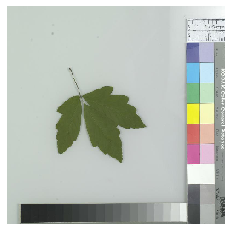

In [94]:
"""Sample Image"""
plt.axis('off')
plt.imshow(train_data.next()[0][0])

Below are more of sample lab images to know how different leaves look.

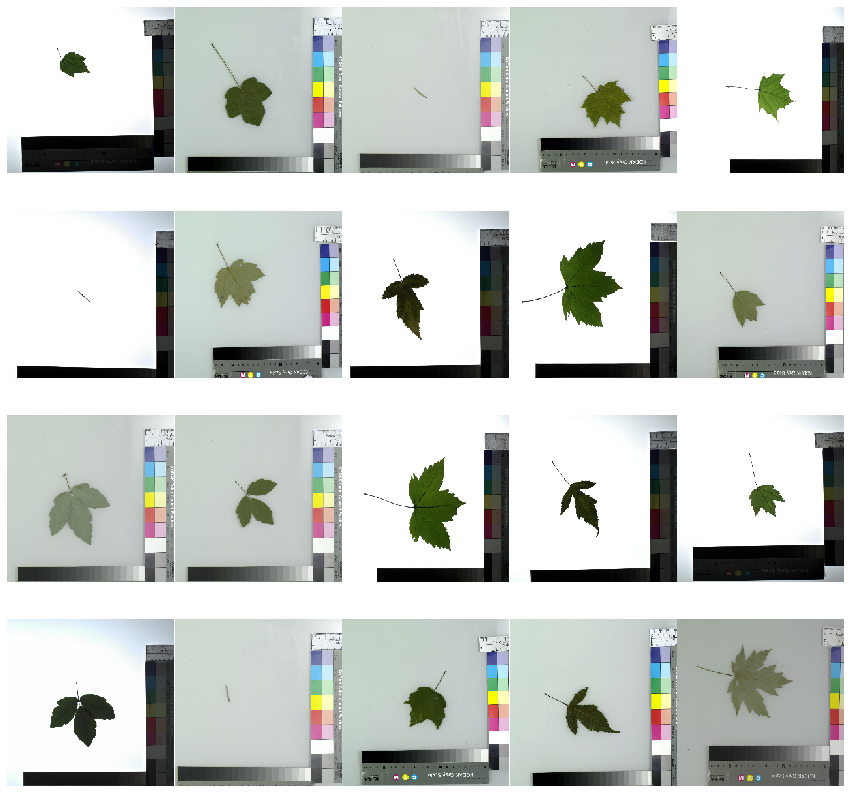

In [95]:
"""More sample images"""
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(train_data.next()[0][0])
plt.subplots_adjust(wspace=0.005, hspace=0.005)

## Exploratory Data Analysis

   Analysing the number of lab images available in each species to work further on creation of CNN

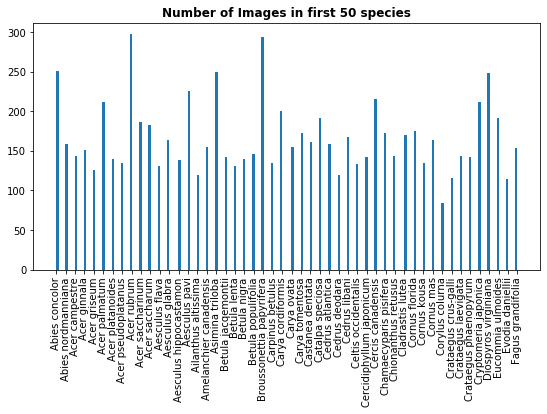

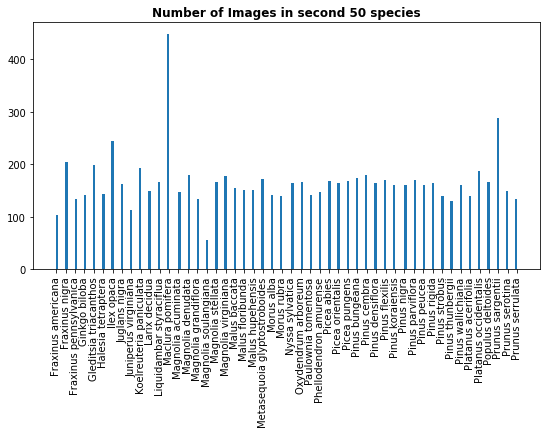

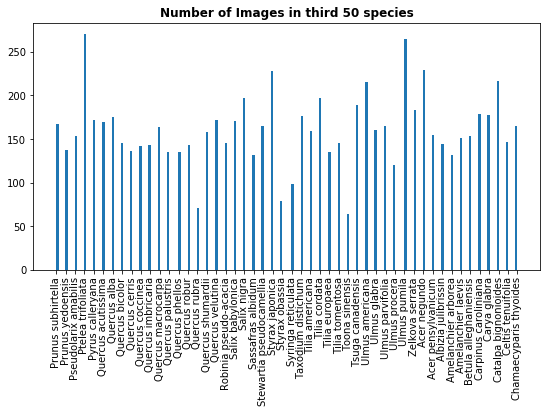

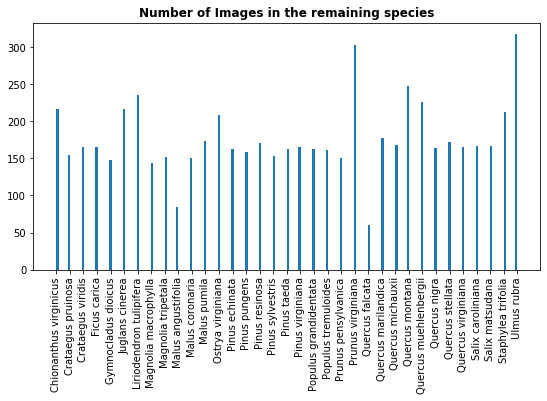

In [6]:
"""Analysing with the histogram of number of images in each species"""
df = pd.read_csv('images.txt', sep='\t')
df.drop(['file_id', 'image_path', 'segmented_path'], axis=1)[df.source == 'lab']

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[:50])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.title("Number of Images in first 50 species", fontweight='bold')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,2)
plt.title("Number of Images in second 50 species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[50:100])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,3)
plt.title("Number of Images in third 50 species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[100:150])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,4)
plt.title("Number of Images in the remaining species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[150:])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

It is understood from histograms that a species typically has around 150-200 images for training which is quite less on constructing a CNN hence we will follow an approach of trying to increase accuracy from the baseline model performance.

## Creating the CNN

For this initial model, we are defining 4 convolutional layers. Each convolutional layer generates a defined set of feature maps activated by activation function 'ReLU', followed a pooling process called MaxPooling(taking maximum of pixel values of a n*n matrix subset of the input matrix) that are fed into next convolutional layer.
Stride value in max pooling indicates the number of steps to be taken left or down in the matrix of pixels.
Activation function 'ReLU' is defined to increase non-linearity in the model and make the model learn faster. A neural network with number of layers starts with Sequential() which tell that there will be layers added to it.
<center>
    <img src="relu.png" width=500 height=500 />
</center>
<br>
<center>
    Fig. ReLU activation function
</center>
<br>
<center>
    <img src="max-pool.png" width=500 height=500 />
</center>
<br>
<center>
    Fig. MaxPooling process
</center>
<br>
CNN description:<br>

Convolutional Layer 1: 10 feature maps, takes input image of size (256,256,3)<br>

Convolutional Layer 2: 512 feature maps, takes input that is pooled output of first convolutional layer<br>

Convolutional Layer 3: 256 feature maps, takes input that is pooled output of second convolutional layer<br>

Convolutional Layer 4: 128 feature maps, takes input that is pooled output of third convolutional layer<br>

Flatten Layer 5: To convert the values of the convolution layers in the form of a vector.<br>

Dropout Layer 6: It is added to reduce the over fitting of the model to training images.It means we eliminate 25% of the values randomly<br>

Dense Layer or Fully connected Layer 7: Takes the vector of values, with again the activation function ReLU and an L2 regularization to reduce the complexity or overfitting of the model.<br>

Dropout Layer 6: It is added to reduce the over fitting of the model to training images. It means we eliminate 20% of the values randomly again.<br>

Dense Layer or Fully connected Layer 7: Takes the vector of values, with again the activation function ReLU and an L2 regularization of alpha 0.01, to reduce the complexity or overfitting of the model.<br>

Dense Layer or Fully connected Layer 7: Takes the vector of values from previous layer, with the activation function 'softmax', to create ouputs in the form of probabilities of each class or species.<br>

In [96]:
"""Defining the convolutional neural network"""
# Sequential model
network = models.Sequential()

# First Convolutional layer with (3,3) matrix size, same padding refers to add additional columns or rows to align
# with the filter and a maxpooling layers which takes maximum value in the (3,3) pixel value matrix.
network.add(layers.Conv2D(10,(3,3), padding='same', activation='relu', input_shape = (256,256,3)))
network.add(layers.MaxPool2D((3,3)))

# Second convolutional layer same as above but this one produces 512 feature maps unlike 10 above.
network.add(layers.Conv2D(512,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Third convolutional layer same as above but this one produces 256 feature maps unlike 512 above.
network.add(layers.Conv2D(256,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Fourth convolutional layer same as above but this one produces 128 feature maps unlike 256 above.
network.add(layers.Conv2D(128,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Flatten layer
network.add(layers.Flatten())

# Dropout layer of 25%
network.add(layers.Dropout(0.25))

# Dense layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Dropout layer of 20% 
network.add(layers.Dropout(0.2))

# Dense Layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Final Dense Layer with number of neurons same as number of classes of classification and 'softmax' as the 
# activation function
# softmax is useful because it converts the output layer into what is essentially a probability distribution.
network.add(layers.Dense(10, activation='softmax'))

## Compiling the model

ADAM optimizer and categorical cross entropy loss function is used during for compiling because 'ADAM' works well in adapting a learning for the CNN and to view training and validation accuracy for each training epoch, we pass the metrics argument. Our goal is to minimize the loss which increses accuracy.

In [97]:
"""Compiling the network"""
# The network has to be compiled before using it for fitting the data.
network.compile(optimizer='adam', 
                loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## Model summary

In [98]:
"""A summary of layers in the neural network"""
network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 256, 256, 10)      280       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 85, 85, 10)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 85, 85, 512)       46592     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 256)       1179904   
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 9, 9, 128)        

## Training the model

In [99]:
"""Fitting the model"""
# the number of steps in each training process or epoch. It is determined by remainder of train_data divided by
# batch size and the same for validation steps
train_steps = train_data.n//train_data.batch_size
val_steps = validation_data.n//validation_data.batch_size
# epochs define the number of times to go through the entire training data.
epochs = 10
train_results = network.fit(train_data, 
                            steps_per_epoch=train_steps, 
                            epochs=epochs,
                            validation_data=validation_data,
                            validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 3 steps
Epoch 1/10
13/13 [==============================] - 37s 3s/step - loss: 11.6575 - accuracy: 0.1538 - val_loss: 8.8725 - val_accuracy: 0.1458
Epoch 2/10
13/13 [==============================] - 36s 3s/step - loss: 7.1922 - accuracy: 0.1790 - val_loss: 5.5418 - val_accuracy: 0.2188
Epoch 3/10
13/13 [==============================] - 35s 3s/step - loss: 4.6441 - accuracy: 0.1850 - val_loss: 3.7520 - val_accuracy: 0.2188
Epoch 4/10
13/13 [==============================] - 35s 3s/step - loss: 3.3056 - accuracy: 0.2128 - val_loss: 2.7912 - val_accuracy: 0.3646
Epoch 5/10
13/13 [==============================] - 36s 3s/step - loss: 2.5785 - accuracy: 0.3519 - val_loss: 2.3232 - val_accuracy: 0.4427
Epoch 6/10
13/13 [==============================] - 36s 3s/step - loss: 2.2090 - accuracy: 0.4764 - val_loss: 2.0554 - val_accuracy: 0.6198
Epoch 7/10
13/13 [==============================] - 36s 3s/step - lo

## Visualizing the training results

In [117]:
def plot_train_results(train_results):
    """This function displays the training results"""
    acc = train_results.history['accuracy']
    val_acc = train_results.history['val_accuracy']

    loss = train_results.history['loss']
    val_loss = train_results.history['val_loss']
    """Using matplotlib to show results"""
    """Below code displays (Training and Validation Accuracy) Vs number of epochs"""

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    """Below code displays (Training and Validation Loss) Vs number of epochs"""

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

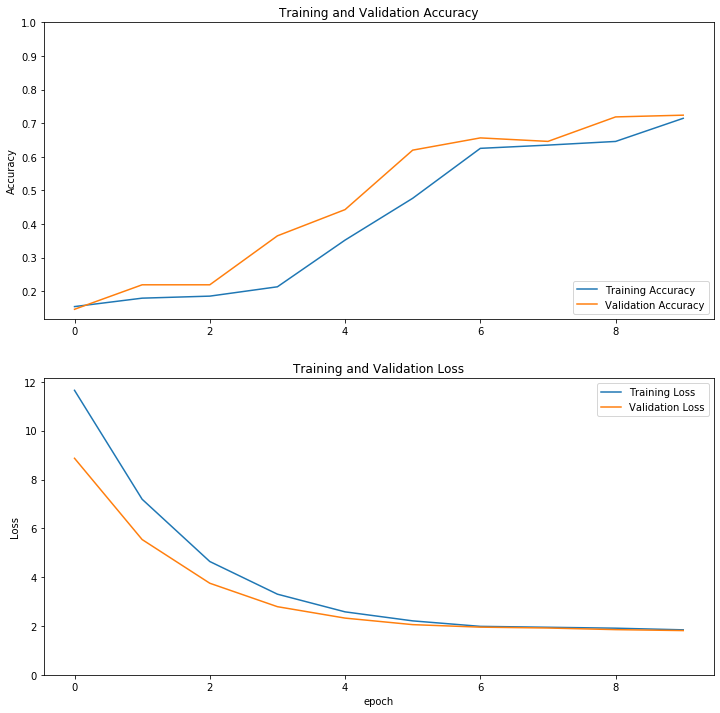

In [106]:
plot_train_results(train_results)

## Displaying test results

In [120]:
def test_results(model, testing_data):
    """ This function is to display the test results of the the CNN model
"""
    test_loss, test_acc = model.evaluate(testing_data, verbose=2)
    print('Test loss: {loss:.2f}'.format(loss=test_loss))
    print('Test accuracy: {acc:.2f}%'.format(acc=test_acc*100))
    return

In [126]:
test_results(network, test_data)

  ...
    to  
  ['...']
5/5 - 3s - loss: 1.8657 - accuracy: 0.6774
Test loss: 1.87
Test accuracy: 67.74%


As it is seen from the plots, training accuracy and validation accuracy are very less off and the model has achieved only around 72% accuracy on the validation set and 67% on the test set. So, we will try to increase accuracy with image augmentation techniques

## Second model using field images

The second model is created to determine which type of images can be used for CNN. We would identify this based on accuracy measeure.

In [13]:
# This data frame consists of image names and the label that is required for 
# creating training images and testing images
"""Creating a dataframe to get the names of images and it's species"""
df = pd.read_csv('images.txt', sep='\t')
df['image_name'] = df[df.source=='field'].reset_index().image_path.str.split("/",expand=True)[4]
df = df[['image_name', 'species']]
df['image_name'] = df.image_name.astype(str)
df.head()

,image_name,species
0,12995307070714.jpg,Abies concolor
1,12995309747806.jpg,Abies concolor
2,12995309740463.jpg,Abies concolor
3,12995309748681.jpg,Abies concolor
4,12995309748490.jpg,Abies concolor


In [14]:
"""Dataframe that shows the image names and the label(species)"""
df_cut = df[df.species.isin(species[:10])]
train, test = train_test_split(df_cut, test_size = 0.2)
"""Displaying sample of training and test rows"""
print("sample training image names with labels of species\n")
print(train.head())
print("sample testing image names with labels of species\n")
print(test.head())

sample training image names with labels of species

               image_name             species
304   1258491080_0003.jpg  Abies nordmanniana
1801   13001917802115.jpg    Acer saccharinum
916    13291664371952.jpg       Acer palmatum
1156   13001274153595.jpg    Acer platanoides
1544   12991999771061.jpg         Acer rubrum
sample testing image names with labels of species

              image_name           species
187   13001148650157.jpg    Abies concolor
1061  13001271789666.jpg  Acer platanoides
1034  13291788884896.jpg     Acer palmatum
1090  13001271785047.jpg  Acer platanoides
543   13033299109239.jpg    Acer campestre


In [15]:
# data generator for training images
image_data = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# data generator for validation images
test_img_data = ImageDataGenerator(rescale=1./255)

In [17]:
"""Data generator that generates training, validation, testing images into target size"""
# Directory of Images
path = 'real_images'

# Extracting images from the path and resizing them to (256,256) size. The same is done for training, valiation,
# testing images.
train_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                            subset='training',
                                           validate_filenames=True)

validation_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                                 subset='validation',
                                           validate_filenames=True)
test_data = test_img_data.flow_from_dataframe(test,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                           validate_filenames=True)

Found 1153 validated image filenames belonging to 10 classes.
Found 288 validated image filenames belonging to 10 classes.
Found 361 validated image filenames belonging to 10 classes.


In [124]:
"""Displaying sample of data generated by ImageDataGenerator"""
print("Sample data for an image: \n", train_data.next()[0][0])
print("\nImages by data generator shape: ", train_data.next()[0].shape)

Sample data for an image: 
 [[[0.4039216  0.48235297 0.4784314 ]
  [0.40000004 0.47450984 0.4666667 ]
  [0.427451   0.4901961  0.48627454]
  ...
  [0.64705884 0.72156864 0.7137255 ]
  [0.61960787 0.69411767 0.6862745 ]
  [0.6313726  0.69411767 0.6901961 ]]

 [[0.41176474 0.4901961  0.48627454]
  [0.4156863  0.4901961  0.48235297]
  [0.4156863  0.4784314  0.47450984]
  ...
  [0.62352943 0.69803923 0.6901961 ]
  [0.63529414 0.70980394 0.7019608 ]
  [0.6313726  0.69411767 0.6901961 ]]

 [[0.41176474 0.4901961  0.48627454]
  [0.4039216  0.4784314  0.47058827]
  [0.43921572 0.5019608  0.49803925]
  ...
  [0.62352943 0.69803923 0.6901961 ]
  [0.6509804  0.7254902  0.7176471 ]
  [0.61960787 0.68235296 0.6784314 ]]

 ...

 [[0.41960788 0.5411765  0.52156866]
  [0.40784317 0.5294118  0.50980395]
  [0.4156863  0.5294118  0.5137255 ]
  ...
  [0.63529414 0.73333335 0.7176471 ]
  [0.64705884 0.74509805 0.7294118 ]
  [0.6313726  0.7294118  0.7137255 ]]

 [[0.41176474 0.5372549  0.5176471 ]
  [0.4196

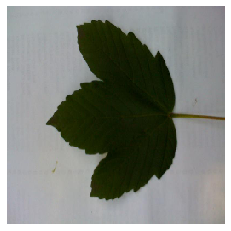

In [106]:
"""Sample Image"""
plt.axis('off')
plt.imshow(train_data.next()[0][0])

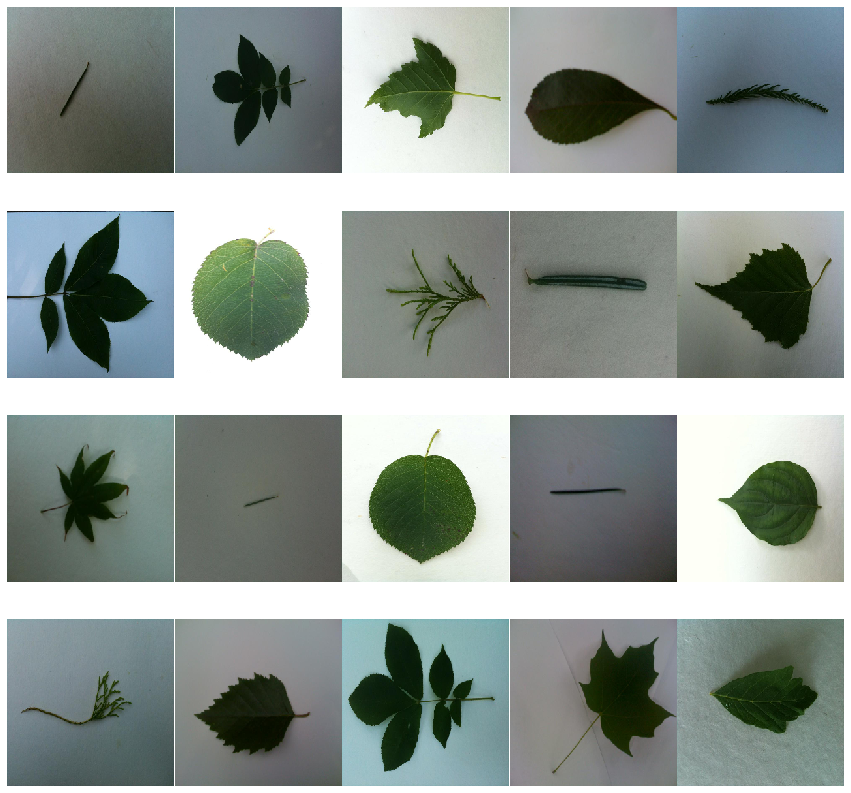

In [122]:
"""More sample images"""
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(train_data.next()[0][0])
plt.subplots_adjust(wspace=0.005, hspace=0.005)

## Exploratory Data Analysis

This analysis revealed number of images in each species and it is understood that the average number of images per species is similar to lab images. 

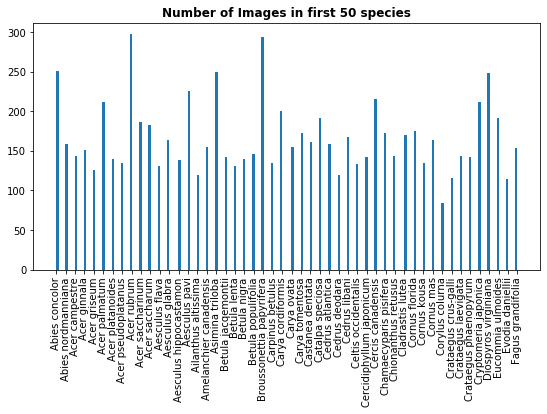

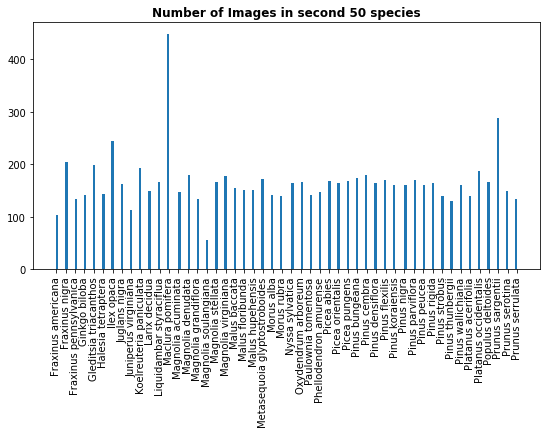

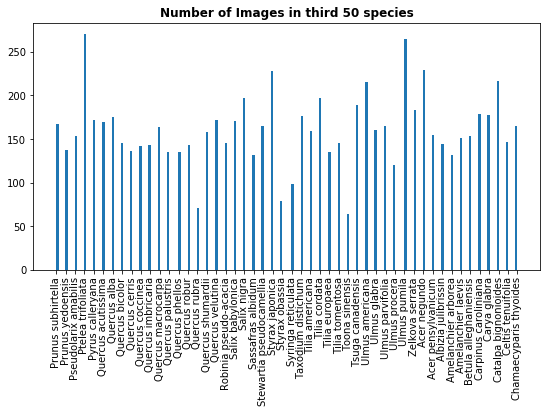

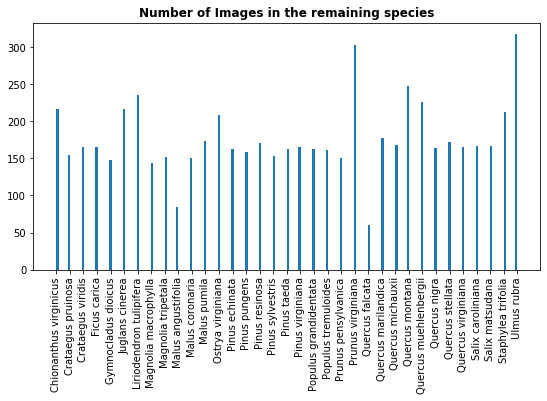

In [125]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[:50])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.title("Number of Images in first 50 species", fontweight='bold')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,2)
plt.title("Number of Images in second 50 species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[50:100])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,3)
plt.title("Number of Images in third 50 species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[100:150])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,4)
plt.title("Number of Images in the remaining species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[150:])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

## Defining the CNN for second model

The second model architecture is similar to above, and only an extra layer of Convolution is added and this shouldn't have any effect on accuracy.

In [109]:
"""Defining the convolutional neural network"""
# Sequential model
network = models.Sequential()

# First Convolutional layer with (3,3) matrix size, same padding refers to add additional columns or rows to align
# with the filter and a maxpooling layers which takes maximum value in the (3,3) pixel value matrix.
network.add(layers.Conv2D(10,(3,3), padding='same', activation='relu', input_shape = (256,256,3)))
network.add(layers.MaxPool2D((3,3)))

# Second convolutional layer same as above but this one produces 512 feature maps unlike 10 above.
network.add(layers.Conv2D(512,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Third convolutional layer same as above but this one produces 256 feature maps unlike 512 above.
network.add(layers.Conv2D(256,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Fourth convolutional layer same as above but this one produces 128 feature maps unlike 256 above.
network.add(layers.Conv2D(128,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Fifth convolutional layer same as above but this one produces 128 feature maps unlike 128 above.
network.add(layers.Conv2D(128,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Flatten layer
network.add(layers.Flatten())

# Dropout layer of 25%
network.add(layers.Dropout(0.25))

# Dense layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Dropout layer of 20% 
network.add(layers.Dropout(0.2))

# Dense Layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Final Dense Layer with number of neurons same as number of classes of classification and 'softmax' as the 
# activation function
# softmax is useful because it converts the output layer into what is essentially a probability distribution.
network.add(layers.Dense(10, activation='softmax'))

## Compiling the model

In [114]:
"""Compiling the network"""
# The network has to be compiled before using it for fitting the data.
network.compile(optimizer='adam', 
                loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## Model Summary

In [115]:
"""A summary of layers in the neural network"""
network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 256, 256, 10)      280       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 85, 85, 10)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 85, 85, 512)       46592     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 256)       1179904   
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 9, 128)        

## Training the model

In [110]:
"""Fitting the model"""
# the number of steps in each training process or epoch. It is determined by remainder of train_data divided by
# batch size and the same for validation steps
train_steps = train_data.n//train_data.batch_size
val_steps = validation_data.n//validation_data.batch_size
# epochs define the number of times to go through the entire training data.
epochs = 10
train_results = network.fit(train_data, 
                            steps_per_epoch=train_steps, 
                            epochs=epochs,
                            validation_data=validation_data,
                            validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18 steps, validate for 4 steps
Epoch 1/10
18/18 [==============================] - 54s 3s/step - loss: 7.6784 - accuracy: 0.1331 - val_loss: 6.1107 - val_accuracy: 0.0664
Epoch 2/10
18/18 [==============================] - 54s 3s/step - loss: 5.0302 - accuracy: 0.1497 - val_loss: 4.2486 - val_accuracy: 0.0664
Epoch 3/10
18/18 [==============================] - 53s 3s/step - loss: 3.6279 - accuracy: 0.1699 - val_loss: 3.3152 - val_accuracy: 0.0938
Epoch 4/10
18/18 [==============================] - 58s 3s/step - loss: 2.8819 - accuracy: 0.2002 - val_loss: 2.9899 - val_accuracy: 0.0898
Epoch 5/10
18/18 [==============================] - 58s 3s/step - loss: 2.6040 - accuracy: 0.2066 - val_loss: 2.5899 - val_accuracy: 0.1680
Epoch 6/10
18/18 [==============================] - 59s 3s/step - loss: 2.3185 - accuracy: 0.2323 - val_loss: 2.4313 - val_accuracy: 0.1797
Epoch 7/10
18/18 [==============================] - 59s 3s/step - los

## Visualizing the training results

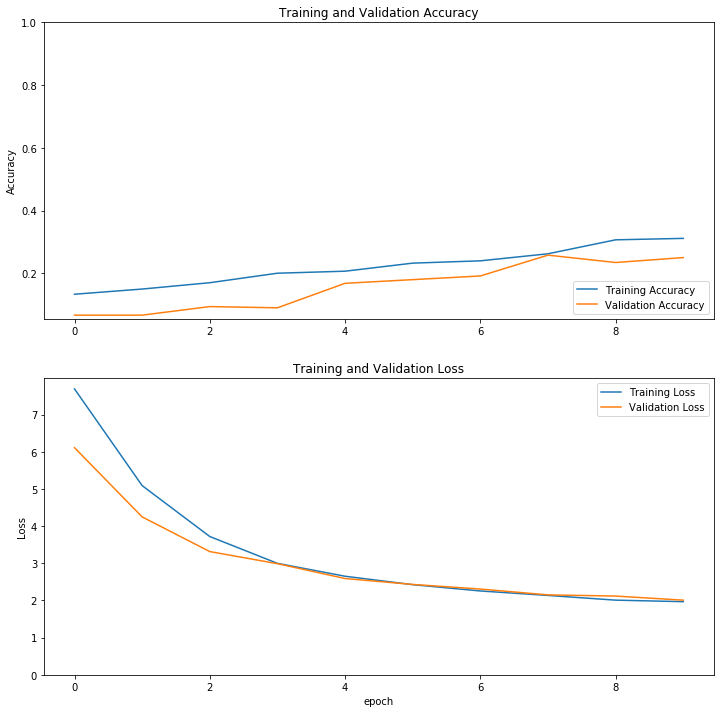

In [118]:
plot_train_results(train_results)

## Printing test results

In [126]:
test_results(network, test_data)

  ...
    to  
  ['...']
6/6 - 4s - loss: 2.3505 - accuracy: 0.2632
Test loss: 2.35
Test accuracy: 26.32%


The interpretation is that lab images are better for CNN for learning that field images as the accuracy of lab images is far better than field images

## Third Model with Image augmentation

Now that the model with lab images has acheived around 70% accuracy, we will try checking with 50 species which is a bit more ambitious with our CNN network. we will also try adding layers to CNN and validate the model performance

### Obtaining dataset of images with species and image names

In [20]:
# This data frame consists of image names and the label that is required for 
# creating training images and testing images
df = pd.read_csv('images.txt', sep='\t')
df['image_name'] = df[df.source == 'lab'].drop(['file_id','source','segmented_path'], 
                                               axis=1)['image_path'].str[-15:]
df = df[df.source == 'lab'][['image_name', 'species']]
species = df.species.unique()
df[['image_name', 'species']]

,image_name,species
0,ny1157-01-1.jpg,Abies concolor
1,ny1157-01-2.jpg,Abies concolor
2,ny1157-01-3.jpg,Abies concolor
3,ny1157-01-4.jpg,Abies concolor
4,ny1157-02-1.jpg,Abies concolor
...,...,...
30812,wb1219-09-4.jpg,Ulmus rubra
30813,wb1219-10-1.jpg,Ulmus rubra
30814,wb1219-10-2.jpg,Ulmus rubra
30815,wb1219-10-3.jpg,Ulmus rubra


### Dividing into training and testing dataset of images

In [21]:
"""Dataframe that shows the image names and the label(species)"""

df_cut = df[df.species.isin(species[:50])]
train, test = train_test_split(df_cut, test_size = 0.2)
print("sample training Image names with labels of species\n")
print(train.head())
print("sample testing Image names with labels of species\n")
print(test.head())

sample training Image names with labels of species

           image_name                   species
753   ny1011-03-1.jpg              Acer griseum
4375  wb1076-05-4.jpg               Carya ovata
5642  ny1038-01-4.jpg  Cercidiphyllum japonicum
4796  wb1414-09-1.jpg          Castanea dentata
5131  ny1138-07-4.jpg          Cedrus atlantica
sample testing Image names with labels of species

           image_name           species
3372  wb1194-03-4.jpg      Betula lenta
5245  ny1147-03-2.jpg    Cedrus deodara
5422  ny1061-07-3.jpg     Cedrus libani
1088  wb1565-07-2.jpg  Acer platanoides
4470  wb1078-09-3.jpg       Carya ovata


### Applying image augmentation

Here we apply image augmentation of adding brightness with range (1,1.5) and zooming images by 2x.

In [22]:
# data generator for training images
image_data = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                zoom_range=2, brightness_range=(1,1.5))
# data generator for validation images
test_img_data = ImageDataGenerator(rescale=1./255)

### Obtaining training, validation, testing images data to be fed into CNN

In [23]:
"""Data generator that generates training, validation, testing images into target size"""
# Directory of Images
path = 'Images_Leafsnap'

# Extracting images from the path and resizing them to (256,256) size. The same is done for training, valiation,
# testing images.
train_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                            subset='training',
                                           validate_filenames=True)

validation_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                                 subset='validation',
                                           validate_filenames=True)
test_data = test_img_data.flow_from_dataframe(test,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                           validate_filenames=True)

Found 4037 validated image filenames belonging to 50 classes.
Found 1009 validated image filenames belonging to 50 classes.
Found 1264 validated image filenames belonging to 50 classes.


/Users/mahi/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


### Sample images after image augmentation

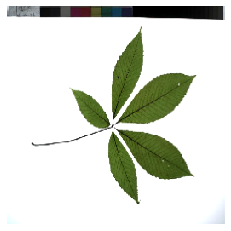

In [177]:
"""Sample Image"""
plt.axis('off')
plt.imshow(train_data.next()[0][0])

In [1]:
"""More sample images"""
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(train_data.next()[0][0])
plt.subplots_adjust(wspace=0.005, hspace=0.005)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NameError: name 'train_data' is not defined

## Defining the CNN for third model

We have added one more convolutional layer because there are more images and 50 species to classify

In [178]:
"""Defining the convolutional neural network"""
# Sequential model
network = models.Sequential()

# First Convolutional layer with (3,3) matrix size, same padding refers to add additional columns or rows to align
# with the filter and a maxpooling layers which takes maximum value in the (3,3) pixel value matrix.
network.add(layers.Conv2D(10,(3,3), padding='same', activation='relu', input_shape = (256,256,3)))
network.add(layers.MaxPool2D((3,3)))

# Second convolutional layer same as above but this one produces 512 feature maps unlike 10 above.
network.add(layers.Conv2D(512,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Third convolutional layer same as above but this one produces 256 feature maps unlike 512 above.
network.add(layers.Conv2D(256,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Fourth convolutional layer same as above but this one produces 128 feature maps unlike 256 above.
network.add(layers.Conv2D(128,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Fifth convolutional layer same as above but this one produces 128 feature maps unlike 128 above.
network.add(layers.Conv2D(128,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Flatten layer
network.add(layers.Flatten())

# Dropout layer of 25%
network.add(layers.Dropout(0.25))

# Dense layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Dropout layer of 20% 
network.add(layers.Dropout(0.2))

# Dense Layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Final Dense Layer with number of neurons same as number of classes of classification and 'softmax' as the 
# activation function
# softmax is useful because it converts the output layer into what is essentially a probability distribution.
network.add(layers.Dense(10, activation='softmax'))

## Compiling the model

Compiling the model with same optimise and loss function as they are proved to imprve CNN's performance.

In [179]:
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the model

In [180]:
train_steps = train_data.n//train_data.batch_size
val_steps = validation_data.n//validation_data.batch_size
epochs = 10
train_results = network.fit(train_data, 
                            steps_per_epoch=train_steps, 
                            epochs=epochs,
                            validation_data=validation_data,
                            validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 15 steps
Epoch 1/10
63/63 [==============================] - 232s 4s/step - loss: 6.7278 - accuracy: 0.0408 - val_loss: 4.5029 - val_accuracy: 0.0271
Epoch 2/10
63/63 [==============================] - 248s 4s/step - loss: 4.0881 - accuracy: 0.0375 - val_loss: 3.9324 - val_accuracy: 0.0271
Epoch 3/10
63/63 [==============================] - 233s 4s/step - loss: 3.8670 - accuracy: 0.0453 - val_loss: 3.8325 - val_accuracy: 0.0552
Epoch 4/10
63/63 [==============================] - 242s 4s/step - loss: 3.7212 - accuracy: 0.0617 - val_loss: 3.6858 - val_accuracy: 0.0500
Epoch 5/10
63/63 [==============================] - 241s 4s/step - loss: 3.6016 - accuracy: 0.0624 - val_loss: 3.6164 - val_accuracy: 0.0490
Epoch 6/10
63/63 [==============================] - 213s 3s/step - loss: 3.5385 - accuracy: 0.0795 - val_loss: 3.5340 - val_accuracy: 0.0604
Epoch 7/10
63/63 [==============================] - 214s 3s/st

## Visualizing the training results

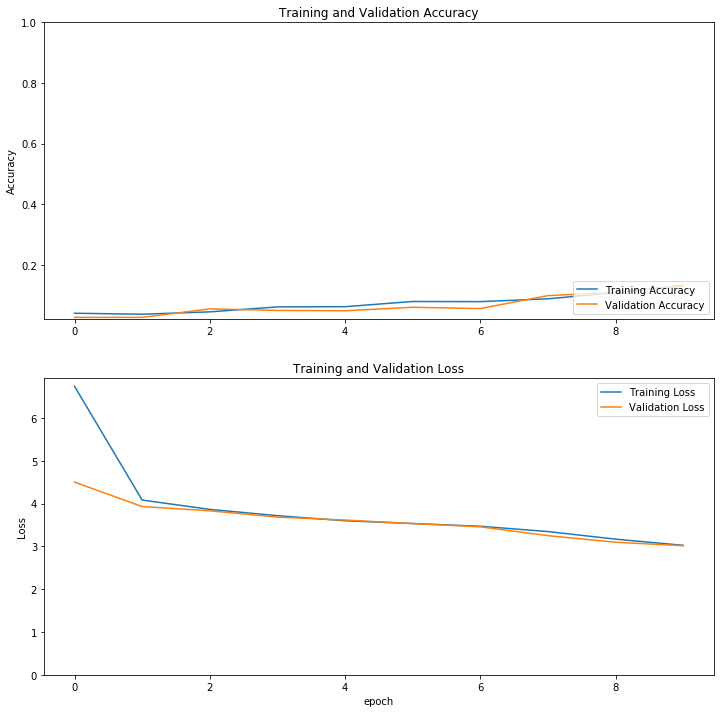

In [181]:
plot_train_results(train_results)

## Displaying the test results

In [182]:
test_results(network, test_data)

  ...
    to  
  ['...']
20/20 - 18s - loss: 2.8164 - accuracy: 0.1544
Test loss: 2.82
Test accuracy: 15.44%


## Interpretation of results

It is observed that the accuracy is not improved and instead it decreased to 15%. The cause of this happening is that dataset there are very few images available for training the network and as adding more leaves, there is the probability of leaves having similar texture or shape and this would downgrade the CNN's learning. Hence, we try with popular ConvNet like VGGNet16 and check if this convolution architecture would help in improving the CNN's performance.

## Fourth Model with VGGNet architecture

### Loading the images from the local directory

In [24]:
# This data frame consists of image names and the label that is required for 
# creating training images and testing images
df = pd.read_csv('images.txt', sep='\t')
df['image_name'] = df[df.source == 'lab'].drop(['file_id','source','segmented_path'], axis=1)['image_path'].str[-15:]
df = df[df.source == 'lab'][['image_name', 'species']]
species = df.species.unique()
# firstly we start with classifying 10 species.
species[:10]

array(['Abies concolor', 'Abies nordmanniana', 'Acer campestre',
       'Acer ginnala', 'Acer griseum', 'Acer palmatum',
       'Acer platanoides', 'Acer pseudoplatanus', 'Acer rubrum',
       'Acer saccharinum'], dtype=object)

### Splitting into testing and training datasets

In [25]:
"""Dataframe that shows the image names and the label(species)"""
df_cut = df[df.species.isin(species[:10])]
train, test = train_test_split(df_cut, test_size = 0.2)
print("sample training Image names with labels of species\n")
print(train.head())
print("sample testing Image names with labels of species\n")
print(test.head())

sample training Image names with labels of species

           image_name         species
39    ny1157-10-4.jpg  Abies concolor
1453  pi2610-04-4.jpg     Acer rubrum
1471  pi2610-09-2.jpg     Acer rubrum
781   ny1011-10-1.jpg    Acer griseum
416   ny1079-02-3.jpg  Acer campestre
sample testing Image names with labels of species

           image_name           species
1566  pi2773-10-1.jpg       Acer rubrum
2     ny1157-01-3.jpg    Abies concolor
197   ny1179-10-2.jpg    Abies concolor
1425  pi2609-07-4.jpg       Acer rubrum
1666  pi0172-09-4.jpg  Acer saccharinum


The Images are loaded using ImageDataGenerator() and the same can be used for augmenting images. Here use rescale the pixel vlaues to range between 0 and 1 as it is quicker in computation.

Using ImageDataGenerator to produce a data of images without image augmentation as it is proved that image augmentation didn't help in our case

In [26]:
# data generator for training images
image_data = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# data generator for validation images
test_img_data = ImageDataGenerator(rescale=1./255)

In [27]:
"""Data generator that generates training, validation, testing images into target size"""
# Directory of Images
path = 'Images_Leafsnap'

# Extracting images from the path and resizing them to (256,256) size. The same is done for training, valiation,
# testing images.
train_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(224,224),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                            subset='training',
                                           validate_filenames=True)

validation_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(224,224),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                                 subset='validation',
                                           validate_filenames=True)
test_data = test_img_data.flow_from_dataframe(test,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(224,224),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                           validate_filenames=True)

Found 891 validated image filenames belonging to 10 classes.
Found 222 validated image filenames belonging to 10 classes.
Found 279 validated image filenames belonging to 10 classes.


## Using VGGNet architechture as a convolutional base

In [206]:
# Sequential Layer
model = models.Sequential()
# First convolutional Layer 
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# Second convolutional Layer 
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# Third convolutional Layer 
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# Fourth convolutional Layer 
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# Fifth convolutional Layer 
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

## Summary of VGGNet architecture

In [207]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 56, 56, 256)     

We add the flatten and dense layers on top of convolutional layer to convert the outputs of VGGNet to predict classes

In [208]:
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, kernel_regularizer = regularizers.l2(0.01),
                         activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01),
                         activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

## Compiling the model

ADAM optimizer and categorical cross entropy loss function is used during for compiling because 'ADAM' works well in adapting a learning for the CNN and to view training and validation accuracy for each training epoch, we pass the metrics argument. Our goal is to minimize the loss which increses accuracy.

In [209]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Summary of the model

In [2]:
model.summary()

NameError: name 'model' is not defined

## Training the model

In [210]:
"""Fitting the model"""
# the number of steps in each training process or epoch. It is determined by remainder of train_data divided by
# batch size and the same for validation steps
train_steps = train_data.n//train_data.batch_size
val_steps = validation_data.n//validation_data.batch_size
# epochs define the number of times to go through the entire training data.
epochs = 10
train_results = model.fit(train_data, 
                            steps_per_epoch=train_steps, 
                            epochs=epochs,
                            validation_data=validation_data,
                            validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 3 steps
Epoch 1/10
13/13 [==============================] - 284s 22s/step - loss: 9.3729 - accuracy: 0.1366 - val_loss: 5.7299 - val_accuracy: 0.1719
Epoch 2/10
13/13 [==============================] - 309s 24s/step - loss: 5.3840 - accuracy: 0.1511 - val_loss: 5.0225 - val_accuracy: 0.2240
Epoch 3/10
13/13 [==============================] - 315s 24s/step - loss: 4.7267 - accuracy: 0.1778 - val_loss: 4.3878 - val_accuracy: 0.2240
Epoch 4/10
13/13 [==============================] - 314s 24s/step - loss: 4.2563 - accuracy: 0.1753 - val_loss: 4.0204 - val_accuracy: 0.2240
Epoch 5/10
13/13 [==============================] - 313s 24s/step - loss: 3.9517 - accuracy: 0.1826 - val_loss: 3.7985 - val_accuracy: 0.2240
Epoch 6/10
13/13 [==============================] - 313s 24s/step - loss: 3.7449 - accuracy: 0.1874 - val_loss: 3.5968 - val_accuracy: 0.2240
Epoch 7/10
13/13 [==============================] - 312s 

## Visualizing the model

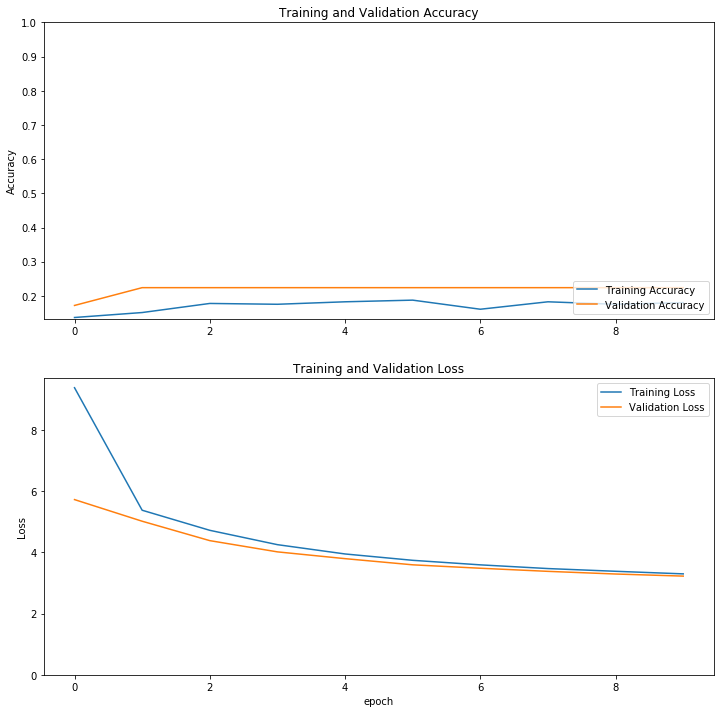

In [213]:
plot_train_results(train_results)

## Displaying the test results

## Interpretation of Results

From this model, it can be understood that even though we used the popular network, it just underperformed than initial performance with only 15%. Hence we would go with greyscaled or segmented images.

In [217]:
test_results(model, test_data)

  ...
    to  
  ['...']
5/5 - 20s - loss: 3.3034 - accuracy: 0.1541
Test loss: 3.30
Test accuracy: 15.41%


## Fifth model by using segmented images for leaves

### Loading the images from the local directory

In [33]:
df = pd.read_excel('real_image_seg.xlsx')
species = df.species.unique()
"""Using 100 species with segmented images as the images are quite easily interpreted"""
df_cut = df[df.species.isin(species[:100])]
# Splitting into testing and training data of images in 100 species
train, test = train_test_split(df_cut, test_size = 0.2)
train

,image_name,species
411,1248106746_0001.png,Acer saccharum
1105,13001271784201.png,Catalpa speciosa
3510,13291700169343.png,Pinus parviflora
2231,1248105728_0003.png,Ilex opaca
104,13291732972527.png,Acer campestre
...,...,...
1832,12991999800320.png,Diospyros virginiana
2133,1259118878_0044.png,Fraxinus pennsylvanica
1894,12992000334286.png,Eucommia ulmoides
957,13001263505253.png,Carya tomentosa


The Images are loaded using ImageDataGenerator() and the same can be used for augmenting images. Here use rescale the pixel vlaues to range between 0 and 1 as it is quicker in computation.

In [34]:
# data generator for training images
image_data = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# data generator for validation images
test_img_data = ImageDataGenerator(rescale=1./255)

The logic of below code its that we sepcify image names, labels that can be used for testing and training through the dataframe described above and various parameters like batch_size, class_mode, target_size are defined to describe the number of images in a batch, type of labels, output image size. These are only a few parameters. However, more can be explored from the tensorflow documentation.

In [35]:
"""Data generator that generates training, validation, testing images into target size"""
# Directory of Images
path = 'real_images_seg'

# Extracting images from the path and resizing them to (256,256) size. The same is done for training, valiation,
# testing images.
train_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='grayscale',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                            subset='training',
                                           validate_filenames=True)

validation_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='grayscale',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                                 subset='validation',
                                           validate_filenames=True)
test_data = test_img_data.flow_from_dataframe(test,
                                           directory=path,
                                           x_col='image_name',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='grayscale',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                           validate_filenames=True)

Found 2544 validated image filenames belonging to 100 classes.
Found 635 validated image filenames belonging to 100 classes.
Found 795 validated image filenames belonging to 99 classes.


In [36]:
"""Displaying sample of data generated by ImageDataGenerator"""
print("Sample data for an image: \n", train_data.next()[0][0])
print("\nImages by data generator shape: ", train_data.next()[0].shape)

Sample data for an image: 
 [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]

Images by data generator shape:  (64, 256, 256, 1)


Each time a batch size of 64 is used and each image has image width as 256 pixels and image height as 256 pixels, 3 indicates it is color coded in 3 channels red, blue, green. Sample image is shown below.

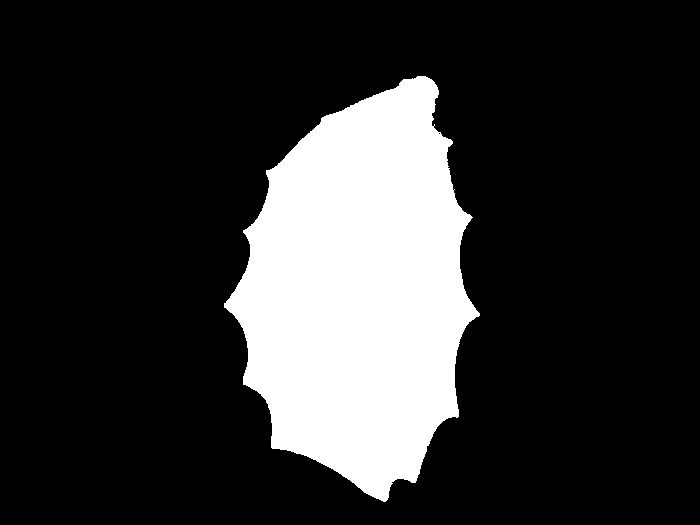

In [37]:
"""Sample Image"""
from IPython.display import display, Image

display(Image(filename='1248105728_0000.png'))

## Exploratory Data Analysis

   Analysing the number of segmented images available in each species.

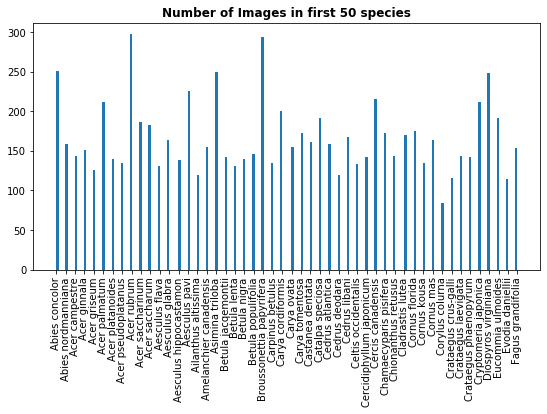

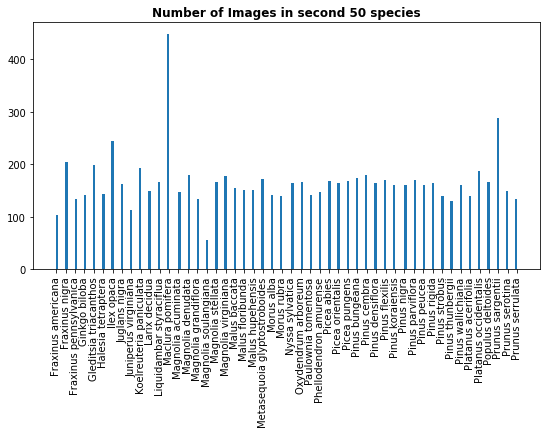

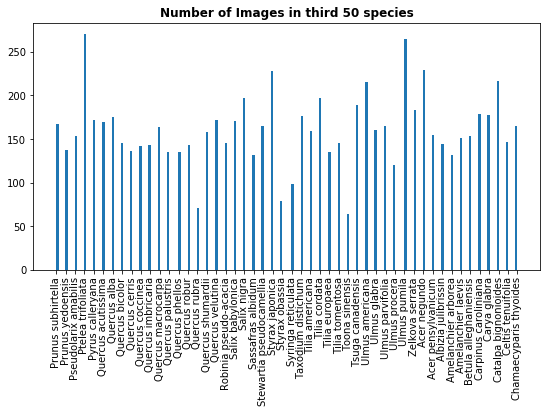

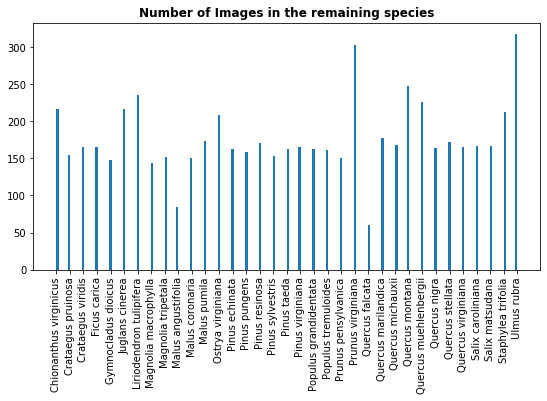

In [38]:
"""Analysing with the histogram of number of images in each species"""
df = pd.read_csv('images.txt', sep='\t')
df.drop(['file_id', 'image_path', 'segmented_path'], axis=1)[df.source == 'lab']

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[:50])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.title("Number of Images in first 50 species", fontweight='bold')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,2)
plt.title("Number of Images in second 50 species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[50:100])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,3)
plt.title("Number of Images in third 50 species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[100:150])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(2,2,4)
plt.title("Number of Images in the remaining species", fontweight='bold')
plt.hist(np.array(df.species[df.species.isin(df.species.unique()[150:])]), bins=200, histtype='barstacked')
plt.xticks(rotation='vertical')
plt.show()

## Defining the CNN
The CNN architecture is similar to first model instead we add one more layer to increase the learning of the images.

In [39]:
"""Defining the convolutional neural network"""
# Sequential model
network = models.Sequential()

# First Convolutional layer with (3,3) matrix size, same padding refers to add additional columns or rows to align
# with the filter and a maxpooling layers which takes maximum value in the (3,3) pixel value matrix.
network.add(layers.Conv2D(10,(3,3), padding='same', activation='relu', input_shape = (256,256,1)))
network.add(layers.MaxPool2D((3,3)))

# Second convolutional layer same as above but this one produces 512 feature maps unlike 10 above.
network.add(layers.Conv2D(512,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Third convolutional layer same as above but this one produces 256 feature maps unlike 512 above.
network.add(layers.Conv2D(256,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Fourth convolutional layer same as above but this one produces 128 feature maps unlike 256 above.
network.add(layers.Conv2D(128,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Fourth convolutional layer same as above but this one produces 128 feature maps unlike 128 above.
network.add(layers.Conv2D(128,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Flatten layer
network.add(layers.Flatten())

# Dropout layer of 25%
network.add(layers.Dropout(0.25))

# Dense layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Dropout layer of 20% 
network.add(layers.Dropout(0.2))

# Dense Layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Final Dense Layer with number of neurons same as number of classes of classification and 'softmax' as the 
# activation function
# softmax is useful because it converts the output layer into what is essentially a probability distribution.
network.add(layers.Dense(100, activation='softmax'))

## Compiling the model

ADAM optimizer and categorical cross entropy loss function is used during for compiling because 'ADAM' works well in adapting a learning for the CNN and to view training and validation accuracy for each training epoch, we pass the metrics argument. Our goal is to minimize the loss which increses accuracy.

In [40]:
"""Compiling the network"""
# The network has to be compiled before using it for fitting the data.
network.compile(optimizer='adam', 
                loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## Model summary

In [41]:
"""A summary of layers in the neural network"""
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 10)      100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 512)       46592     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       1179904   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         2

In [ ]:
"""Fitting the model"""
# the number of steps in each training process or epoch. It is determined by remainder of train_data divided by
# batch size and the same for validation steps
train_steps = train_data.n//train_data.batch_size
val_steps = validation_data.n//validation_data.batch_size
# epochs define the number of times to go through the entire training data.
epochs = 10
train_results = network.fit(train_data, 
                            steps_per_epoch=train_steps, 
                            epochs=epochs,
                            validation_data=validation_data,
                            validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 9 steps
Epoch 1/10
39/39 [==============================] - 105s 3s/step - loss: 8.2744 - accuracy: 0.0403 - val_loss: 5.9042 - val_accuracy: 0.0503
Epoch 2/10
39/39 [==============================] - 104s 3s/step - loss: 5.1741 - accuracy: 0.0440 - val_loss: 4.7494 - val_accuracy: 0.0503
Epoch 3/10
39/39 [==============================] - 107s 3s/step - loss: 4.6519 - accuracy: 0.0460 - val_loss: 4.5852 - val_accuracy: 0.0625
Epoch 4/10
39/39 [==============================] - 110s 3s/step - loss: 4.5775 - accuracy: 0.0593 - val_loss: 4.5613 - val_accuracy: 0.0660
Epoch 5/10
39/39 [==============================] - 107s 3s/step - loss: 4.5737 - accuracy: 0.0585 - val_loss: 4.5655 - val_accuracy: 0.0677
Epoch 6/10
39/39 [==============================] - 97s 2s/step - loss: 4.5667 - accuracy: 0.0625 - val_loss: 4.5601 - val_accuracy: 0.0677
Epoch 7/10
39/39 [==============================] - 106s 3s/step

## Visualizing the training results

In [ ]:
plot_train_results(train_results)

## Displaying the test results

In [ ]:
test_results(network, test_data)

## Conclusion

1. It is understood that initially the CNN worked very good for lab images without image augmentation and 4 layers of convolution with more generation of feature maps in each layer.
2. Secondly, the model is tested with image augmentation and field real-like images, this caused the CNN to not work well but with number of species made less for classfication the model works better for both field and lab images.
3. Third approach is to use popular convolutional base for improving accuracy, however the model has not reached the benchmark of initial accuracy.
4. Finally, with the segmented images of original images may perform better as they generate an image with only the image and blacked everywhere as it can be easy for CNN to learn with just two channels of images.
5. The final suggestion of improvement is to use the CNN for training all species of images and generate the probabilities of classification of an image and generate the label or species with the highest probability.
6. It is suggested to use a CNN with 10 species classification out of 185 here, for training wholeset of images 10 species at a time and create a probability distribution and finally labelling the one with highest probability.

# Author
    Mahesh Kumar Badam Venkata
    Master of Science in Applied Data Science
    Syracuse University, Syracuse, NY

# Citation

**References:**<br>
1. "Leafsnap: A Computer Vision System for Automatic Plant Species Identification," Neeraj Kumar, Peter N. Belhumeur, Arijit Biswas, David W. Jacobs, W. John Kress, Ida C. Lopez, João V. B. Soares, Proceedings of the 12th European Conference on Computer Vision (ECCV), October 2012
2. ADL (24 April 2018), "*An intuitive guide to Convolutional Neural Networks*" retrieved from https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/
3. TensorFlow Tutorials,"*Convolutional Neural Network (CNN)*" retrieved from https://www.tensorflow.org/tutorials/images/cnn
4. Analytics Vidhya Courses, "*Convolutional Neural Networks (CNN) from Scratch*" retrieved from https://courses.analyticsvidhya.com/courses/take/convolutional-neural-networks-cnn-from-scratch/texts/10844923-what-is-a-neural-network
5. TensorFlow Core Documentation, "*Module: tf.keras*" retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/

MIT License

Copyright (c) 2020 Mahesh Kumar Badam Venkata

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.